# Notebook 24 — Analyse Graphe Spatial et Similarité IMD (France)

**Résumé** : Ce notebook applique des méthodes de science des réseaux à l'Indice de Mobilité Douce (IMD)
calculé pour 60 agglomérations françaises (notebook 21). Nous construisons un graphe spatial k-NN (k=5)
basé sur la proximité géographique et calculons l'autocorrélation spatiale globale (Moran's I) et locale
(LISA — Local Indicators of Spatial Association). Nous construisons également un graphe de similarité
basé sur les 5 composantes IMD pour identifier des « villes pairs » et formuler des recommandations
d'apprentissage par les pairs.

**Questions de recherche** :
1. L'IMD présente-t-il une autocorrélation spatiale significative en France ?
2. Quels clusters géographiques se forment (HH/LL/HL/LH) ?
3. Quelles villes peuvent servir de modèles pour leurs homologues sous-performantes ?

**Méthodes** : Moran's I global, LISA avec test de permutation (999 itérations), graphe k-NN spatial,
graphe de similarité euclidienne dans l'espace des composantes IMD.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
print("Libraries loaded ✓")


Libraries loaded ✓


In [4]:
import os
OUTPUT_DIR  = "../../output/24_Graph_Spatial_IMD"
FIGURES_DIR = f"{OUTPUT_DIR}/figures"
TABLES_DIR  = f"{OUTPUT_DIR}/tables_csv"

K_SPATIAL   = 5    # k-NN spatial neighbors
N_PERM      = 999  # permutation test iterations
ALPHA       = 0.05 # significance threshold
K_SIM       = 3    # similarity graph neighbors

os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)
print("Output directories ready ✓")


Output directories ready ✓


In [5]:
df_imd = pd.read_csv(
    "../../output/21_Classement_Villes_Mobilite_Douce/tables_csv/imd_classement.csv"
)
print(f"Villes chargées : {len(df_imd)}")
print(df_imd[['rang','city','C1_S','C2_E','C3_D','C4_P','C5_M','IMD']].head(10).to_string())


Villes chargées : 62
   rang              city    C1_S    C2_E      C3_D      C4_P      C5_M     IMD
0     1            Nantes  0.7855  0.8091  1.000000  0.219729  0.666667  0.7376
1     2             Nancy  0.8112  0.8709  0.783740  0.205840  0.333333  0.6820
2     3            Rennes  0.6312  0.8574  0.836352  0.154554  0.666667  0.6608
3     4            Amiens  0.7495  0.8313  0.817146  0.194555  0.333333  0.6586
4     5         Périgueux  1.0000  1.0000  0.228334  0.064457  0.333333  0.6387
5     6       Carcassonne  0.8256  0.5977  0.813886  0.127981  0.333333  0.6124
6     7          Bordeaux  0.3966  0.7834  0.652167  0.416871  1.000000  0.6078
7     8             Auray  0.5915  0.7861  0.652167  0.392122  0.333333  0.5966
8     9  La Roche-sur-Yon  0.6159  0.8304  0.687292  0.000000  0.666667  0.5965
9    10             Paris  0.4606  0.7939  0.845734  0.089111  0.666667  0.5858


In [6]:
CITY_COORDS = {
    'Nantes':                (47.2184, -1.5536),
    'Nancy':                 (48.6921,  6.1844),
    'Rennes':                (48.1173, -1.6778),
    'Amiens':                (49.8941,  2.2958),
    'Périgueux':             (45.1845,  0.7214),
    'Carcassonne':           (43.2117,  2.3533),
    'Bordeaux':              (44.8378, -0.5792),
    'Auray':                 (47.6682, -2.9834),
    'La Roche-sur-Yon':      (46.6706, -1.4268),
    'Paris':                 (48.8566,  2.3522),
    'Lille':                 (50.6292,  3.0573),
    'Marseille':             (43.2965,  5.3698),
    'Argelès-sur-Mer':       (42.5454,  3.0222),
    'Bourg-en-Bresse':       (46.2057,  5.2250),
    'Cergy-Pontoise':        (49.0367,  2.0834),
    'Toulouse':              (43.6047,  1.4442),
    'La Baule':              (47.2863, -2.3985),
    'Belfort':               (47.6382,  6.8633),
    'Saint-Brieuc':          (48.5139, -2.7654),
    'Clermont-Ferrand':      (45.7774,  3.0870),
    'PAU':                   (43.2951, -0.3708),
    "Les Sables-d'Olonne":   (46.4968, -1.7845),
    'Vichy':                 (46.1280,  3.4266),
    'Épinal':                (48.1739,  6.4505),
    'Mulhouse':              (47.7509,  7.3359),
    'Landerneau':            (48.4500, -4.2522),
    'Troyes':                (48.2973,  4.0744),
    'Reims':                 (49.2583,  4.0317),
    'Niort':                 (46.3234, -0.4663),
    'Longwy':                (49.5218,  5.7643),
    'Cholet':                (47.0601, -0.8795),
    'Brest':                 (48.3904, -4.4861),
    'Agen':                  (44.2010,  0.6200),
    'Calais':                (50.9513,  1.8587),
    'Avignon':               (43.9493,  4.8055),
    'Soissons':              (49.3827,  3.3228),
    'Royan':                 (45.6250, -1.0297),
    'Caen':                  (49.1829, -0.3707),
    'Brive-la-Gaillarde':    (45.1555,  1.5329),
    'Libourne':              (44.9193, -0.2421),
    'Valence':               (44.9333,  4.8975),
    'Chantrerie':            (47.2731, -1.6085),
    'Louviers':              (49.2225,  1.1672),
    'Auxerre':               (47.7958,  3.5672),
    'Laon':                  (49.5644,  3.6243),
    'Angers':                (47.4784, -0.5632),
    'Annecy':                (45.8992,  6.1294),
    'Lyon':                  (45.7485,  4.8467),
    'Ardenne Métropole':     (49.7709,  4.7169),
    'Besançon':              (47.2378,  6.0241),
    'Saint-Étienne':         (45.4397,  4.3872),
    'Strasbourg':            (48.5734,  7.7521),
    'Cherbourg-en-Cotentin': (49.6333, -1.6171),
    'Saint-Nazaire':         (47.2833, -2.2000),
    'Châtellerault':         (46.8169,  0.5369),
    'Tarbes':                (43.2333,  0.0778),
    'Grenoble':              (45.1885,  5.7245),
    'Montreuil-Bellay':      (47.1330, -0.1595),
    # Overseas (excluded from spatial graph)
    'Pointe-à-Pitre':        (16.2410, -61.5330),
    'La Réunion':            (-20.8789, 55.4796),
}

OVERSEAS = {'Pointe-à-Pitre', 'La Réunion'}
df_metro = df_imd[~df_imd['city'].isin(OVERSEAS)].copy()
df_metro['lat'] = df_metro['city'].map(lambda c: CITY_COORDS.get(c, (None,None))[0])
df_metro['lon'] = df_metro['city'].map(lambda c: CITY_COORDS.get(c, (None,None))[1])
df_metro = df_metro.dropna(subset=['lat','lon']).reset_index(drop=True)

print(f"Villes métropolitaines  : {len(df_metro)}")
print(f"Villes outre-mer exclues: {df_imd['city'].isin(OVERSEAS).sum()}")
missing = set(df_metro['city']) - set(CITY_COORDS.keys())
if missing:
    print(f"ATTENTION — coordonnées manquantes : {missing}")


Villes métropolitaines  : 58
Villes outre-mer exclues: 2


In [7]:
coords = df_metro[['lat','lon']].values
n      = len(df_metro)
IMD    = df_metro['IMD'].values

knn = NearestNeighbors(n_neighbors=K_SPATIAL + 1, metric='haversine')
knn.fit(np.radians(coords))
distances, indices = knn.kneighbors(np.radians(coords))

W_binary = np.zeros((n, n))
edge_list = []
for i in range(n):
    for j in indices[i, 1:]:   # skip self (column 0)
        W_binary[i, j] = 1
        edge_list.append((i, int(j)))

row_sums = W_binary.sum(axis=1, keepdims=True)
W = W_binary / row_sums         # row-standardised weight matrix

print(f"W : {n}×{n}, {int(W_binary.sum())} arêtes dirigées")
print(f"k-NN k={K_SPATIAL} — matrice row-standardisée ✓")
print(f"Arêtes non orientées uniques : {len(set(tuple(sorted(e)) for e in edge_list))}")


W : 58×58, 290 arêtes dirigées
k-NN k=5 — matrice row-standardisée ✓
Arêtes non orientées uniques : 188


In [8]:
def global_morans_I(values, W_matrix, n_perm=999, seed=42):
    np.random.seed(seed)
    n   = len(values)
    z   = values - values.mean()
    S0  = W_matrix.sum()
    Wz  = W_matrix @ z
    I_obs = (n / S0) * (z @ Wz) / (z @ z)

    I_sim = np.zeros(n_perm)
    for k in range(n_perm):
        zp      = np.random.permutation(z)
        I_sim[k] = (n / S0) * (zp @ (W_matrix @ zp)) / (zp @ zp)

    p_value = (np.sum(np.abs(I_sim) >= np.abs(I_obs)) + 1) / (n_perm + 1)
    E_I     = -1 / (n - 1)
    z_score = (I_obs - I_sim.mean()) / I_sim.std()
    return I_obs, p_value, E_I, z_score, I_sim

I_obs, p_moran, E_I, z_score, I_sim = global_morans_I(IMD, W, N_PERM)

stars = '***' if p_moran < 0.001 else '**' if p_moran < 0.01 else '*' if p_moran < 0.05 else 'NS'
print("=" * 45)
print(f"  Moran's I global")
print("=" * 45)
print(f"  I observé       = {I_obs:+.4f}")
print(f"  E[I] sous H0    = {E_I:+.4f}")
print(f"  Z-score         = {z_score:+.3f}")
print(f"  p-valeur (perm) = {p_moran:.4f}  {stars}")
print("=" * 45)
interp = 'Clustering spatial POSITIF significatif' if I_obs > E_I and p_moran < ALPHA else 'Pas de clustering significatif'
print(f"  → {interp}")


  Moran's I global
  I observé       = -0.0231
  E[I] sous H0    = -0.0175
  Z-score         = -0.094
  p-valeur (perm) = 0.7650  NS
  → Pas de clustering significatif


In [9]:
def compute_LISA(values, W_matrix, n_perm=999, alpha=0.05, seed=42):
    np.random.seed(seed)
    n    = len(values)
    z    = (values - values.mean()) / values.std()
    Wz   = W_matrix @ z
    Li   = z * Wz

    p_values = np.zeros(n)
    for i in range(n):
        others = np.delete(np.arange(n), i)
        Li_sim = np.zeros(n_perm)
        for k in range(n_perm):
            zp         = z.copy()
            zp[others] = np.random.permutation(z[others])
            Li_sim[k]  = zp[i] * (W_matrix[i] @ zp)
        p_values[i] = (np.sum(np.abs(Li_sim) >= np.abs(Li[i])) + 1) / (n_perm + 1)

    labels = []
    for i in range(n):
        if p_values[i] > alpha:
            labels.append('NS')
        elif z[i] > 0 and Wz[i] > 0:
            labels.append('HH')
        elif z[i] < 0 and Wz[i] < 0:
            labels.append('LL')
        elif z[i] > 0 and Wz[i] < 0:
            labels.append('HL')
        else:
            labels.append('LH')
    return Li, p_values, np.array(labels), z, Wz

Li, p_lisa, lisa_labels, z_std, Wz_std = compute_LISA(IMD, W, N_PERM)

df_metro = df_metro.copy()
df_metro['Li']         = Li
df_metro['p_lisa']     = p_lisa
df_metro['lisa_label'] = lisa_labels
df_metro['z_std']      = z_std
df_metro['Wz_std']     = Wz_std

print("=== Distribution LISA ===")
print(df_metro['lisa_label'].value_counts().to_string())
print()
sig = df_metro[df_metro['lisa_label'] != 'NS'][
    ['city','IMD','lisa_label','p_lisa']
].sort_values('lisa_label')
print("--- Villes significatives (p < 0.05) ---")
print(sig.to_string(index=False))


=== Distribution LISA ===
lisa_label
NS    56
HL     1
LH     1

--- Villes significatives (p < 0.05) ---
           city    IMD lisa_label  p_lisa
Bourg-en-Bresse 0.5238         HL   0.008
  Saint-Nazaire 0.3014         LH   0.012


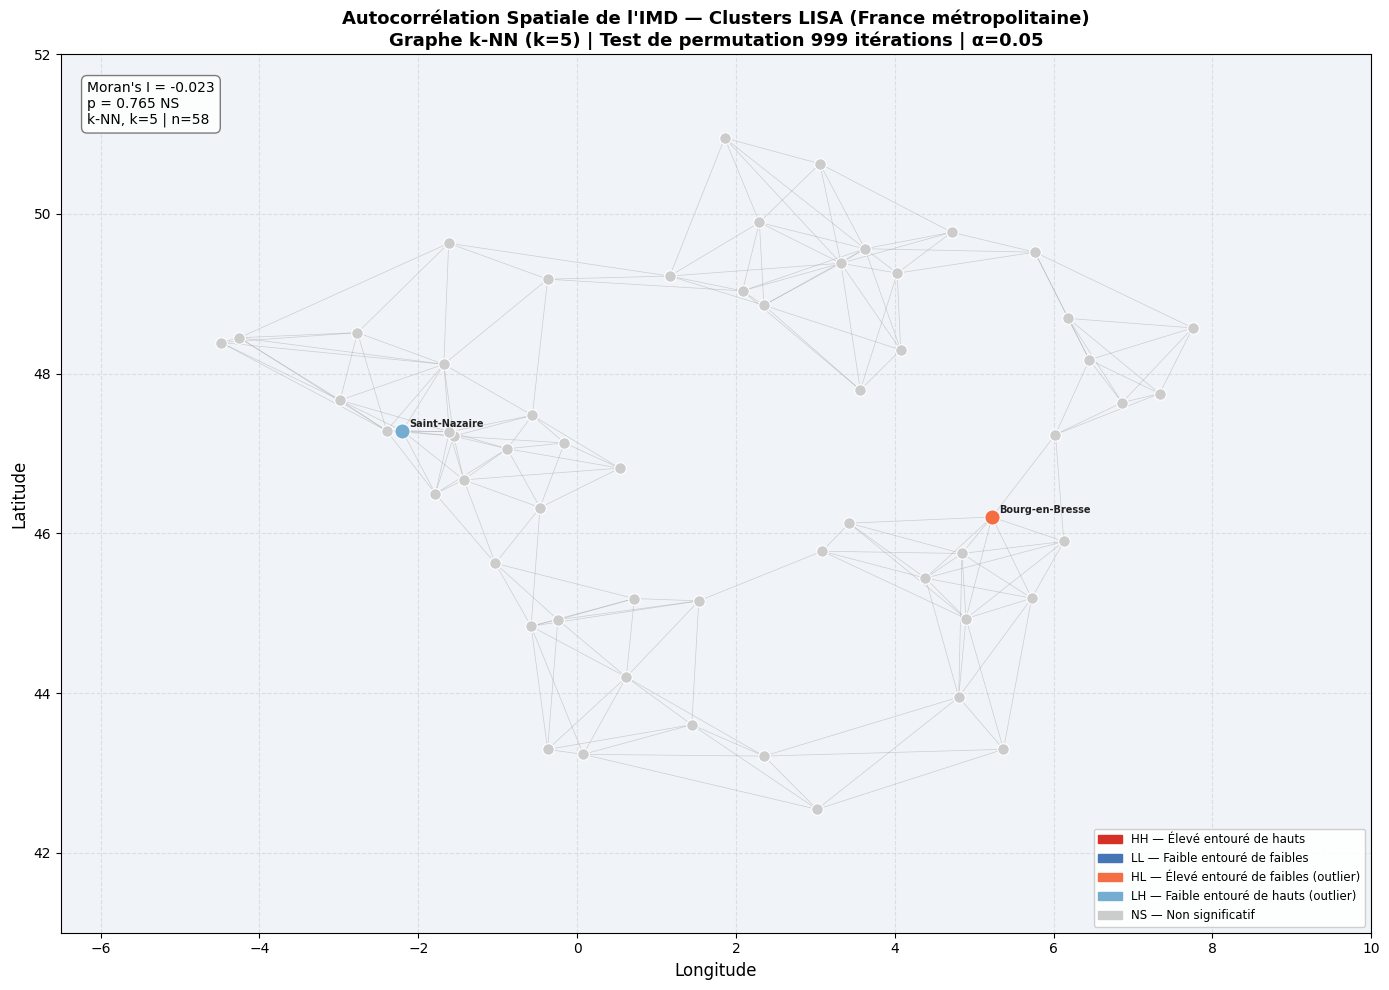

Figure A sauvegardée → ../../output/24_Graph_Spatial_IMD/figures/fig_A_lisa_clusters_map.png


In [10]:
LISA_COLORS = {
    'HH': '#d73027', 'LL': '#4575b4',
    'HL': '#f46d43', 'LH': '#74add1', 'NS': '#cccccc'
}
LISA_LABELS_FR = {
    'HH': 'HH — Élevé entouré de hauts',
    'LL': 'LL — Faible entouré de faibles',
    'HL': 'HL — Élevé entouré de faibles (outlier)',
    'LH': 'LH — Faible entouré de hauts (outlier)',
    'NS': 'NS — Non significatif'
}

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_facecolor('#f0f4f8')
fig.patch.set_facecolor('white')

# Draw k-NN edges (undirected, de-duplicated)
drawn = set()
for i, j in edge_list:
    key = (min(i, j), max(i, j))
    if key not in drawn:
        drawn.add(key)
        ax.plot([df_metro.iloc[i]['lon'], df_metro.iloc[j]['lon']],
                [df_metro.iloc[i]['lat'], df_metro.iloc[j]['lat']],
                color='#888888', linewidth=0.5, alpha=0.35, zorder=1)

# Draw cities
for _, row in df_metro.iterrows():
    c = LISA_COLORS[row['lisa_label']]
    sz = 120 if row['lisa_label'] != 'NS' else 70
    ax.scatter(row['lon'], row['lat'], c=c, s=sz, zorder=3,
               edgecolors='white', linewidths=0.8)
    if row['lisa_label'] != 'NS':
        ax.annotate(row['city'], (row['lon'], row['lat']),
                    textcoords='offset points', xytext=(5, 3),
                    fontsize=7, zorder=4, color='#222222',
                    fontweight='bold')

# Moran's I box
stars = '***' if p_moran < 0.001 else '**' if p_moran < 0.01 else '*' if p_moran < 0.05 else 'NS'
ax.text(0.02, 0.97,
    f"Moran's I = {I_obs:.3f}\n"
    f"p = {p_moran:.3f} {stars}\n"
    f"k-NN, k={K_SPATIAL} | n={len(df_metro)}",
    transform=ax.transAxes, fontsize=10, va='top',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='#666'))

# Legend
patches = [mpatches.Patch(color=v, label=LISA_LABELS_FR[k]) for k, v in LISA_COLORS.items()]
ax.legend(handles=patches, loc='lower right', fontsize=8.5, framealpha=0.92)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(
    "Autocorrélation Spatiale de l'IMD — Clusters LISA (France métropolitaine)\n"
    f"Graphe k-NN (k={K_SPATIAL}) | Test de permutation {N_PERM} itérations | α=0.05",
    fontsize=13, fontweight='bold')
ax.set_xlim(-6.5, 10); ax.set_ylim(41, 52)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_A_lisa_clusters_map.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure A sauvegardée → {fig_path}")


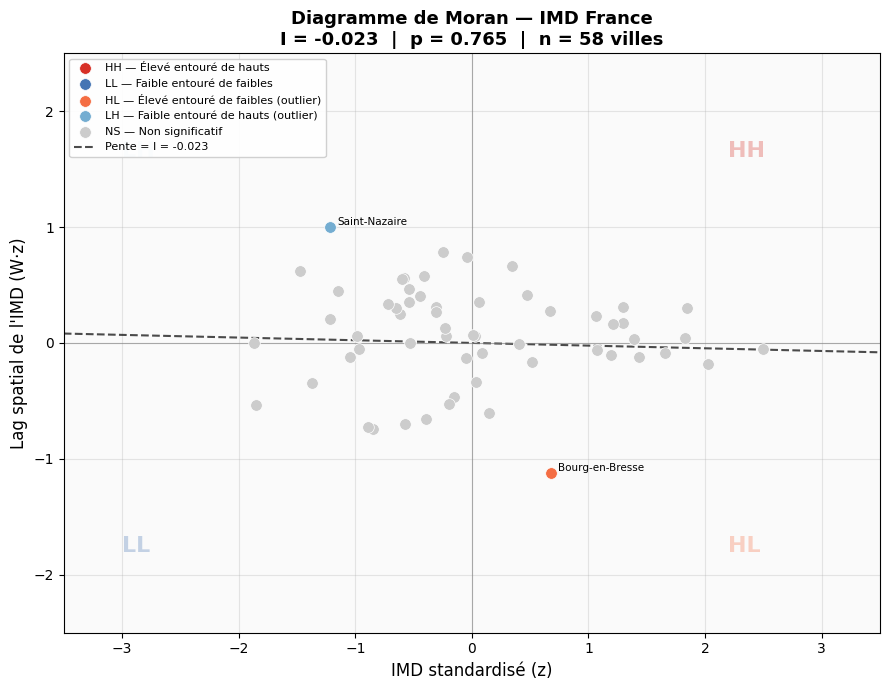

Figure B sauvegardée → ../../output/24_Graph_Spatial_IMD/figures/fig_B_moran_scatter.png


In [11]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_facecolor('#fafafa')

for label, color in LISA_COLORS.items():
    mask = df_metro['lisa_label'] == label
    ax.scatter(df_metro.loc[mask, 'z_std'], df_metro.loc[mask, 'Wz_std'],
               c=color, s=70, label=LISA_LABELS_FR[label],
               edgecolors='white', linewidths=0.5, zorder=3)

# Annotate significant cities
for _, row in df_metro[df_metro['lisa_label'] != 'NS'].iterrows():
    ax.annotate(row['city'], (row['z_std'], row['Wz_std']),
                textcoords='offset points', xytext=(5, 2), fontsize=7.5)

# Slope = Moran's I
x_line = np.array([-3.5, 3.5])
ax.plot(x_line, I_obs * x_line, 'k--', lw=1.5, alpha=0.7, label=f"Pente = I = {I_obs:.3f}")

ax.axhline(0, color='gray', lw=0.8, alpha=0.6)
ax.axvline(0, color='gray', lw=0.8, alpha=0.6)

# Quadrant labels
for x, y, txt, col in [(2.2, 1.6, 'HH', '#d73027'), (-3.0, 1.6, 'LH', '#74add1'),
                        (2.2, -1.8, 'HL', '#f46d43'), (-3.0, -1.8, 'LL', '#4575b4')]:
    ax.text(x, y, txt, fontsize=16, color=col, alpha=0.3, fontweight='bold')

ax.set_xlabel("IMD standardisé (z)", fontsize=12)
ax.set_ylabel("Lag spatial de l'IMD (W·z)", fontsize=12)
ax.set_title(
    f"Diagramme de Moran — IMD France\n"
    f"I = {I_obs:.3f}  |  p = {p_moran:.3f}  |  n = {len(df_metro)} villes",
    fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=8, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3.5, 3.5); ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_B_moran_scatter.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure B sauvegardée → {fig_path}")


In [12]:
components  = ['C1_S','C2_E','C3_D','C4_P','C5_M']
X           = df_metro[components].values
D_comp      = cdist(X, X, metric='euclidean')   # (n × n)
imd_vals    = df_metro['IMD'].values
imd_median  = np.median(imd_vals)
cities      = df_metro['city'].tolist()
n           = len(df_metro)

# k-NN similarity edges
sim_edges = []
for i in range(n):
    d = D_comp[i].copy(); d[i] = np.inf
    for j in np.argsort(d)[:K_SIM]:
        sim_edges.append((i, int(j), D_comp[i, j]))

# Peer recommendations
above_pos = [i for i, v in enumerate(imd_vals) if v >= imd_median]
recs = []
for i, v in enumerate(imd_vals):
    if v < imd_median:
        best = min(above_pos, key=lambda j: D_comp[i, j])
        recs.append({
            'ville_source':        cities[i],
            'IMD_source':          round(float(imd_vals[i]), 4),
            'ville_pair':          cities[best],
            'IMD_pair':            round(float(imd_vals[best]), 4),
            'distance_composante': round(float(D_comp[i, best]), 4),
            'delta_IMD':           round(float(imd_vals[best] - imd_vals[i]), 4),
        })

df_recs = pd.DataFrame(recs).sort_values('IMD_source')
print(f"Médiane IMD : {imd_median:.3f}")
print(f"Villes sous la médiane : {len(df_recs)}")
print()
print(df_recs[['ville_source','IMD_source','ville_pair','IMD_pair','delta_IMD']].to_string(index=False))


Médiane IMD : 0.420
Villes sous la médiane : 29

         ville_source  IMD_source ville_pair  IMD_pair  delta_IMD
     Montreuil-Bellay      0.2251      Reims    0.4266     0.2015
             Grenoble      0.2265      Vichy    0.4485     0.2220
               Tarbes      0.2709      Niort    0.4213     0.1504
        Châtellerault      0.2835      Vichy    0.4485     0.1650
        Saint-Nazaire      0.3014        PAU    0.4539     0.1525
Cherbourg-en-Cotentin      0.3017      Niort    0.4213     0.1196
           Strasbourg      0.3095      Vichy    0.4485     0.1390
        Saint-Étienne      0.3212 Landerneau    0.4392     0.1180
             Besançon      0.3289      Vichy    0.4485     0.1196
    Ardenne Métropole      0.3301 Landerneau    0.4392     0.1091
                 Lyon      0.3392      Vichy    0.4485     0.1093
               Annecy      0.3449 Landerneau    0.4392     0.0943
               Angers      0.3599      Vichy    0.4485     0.0886
                 Laon      

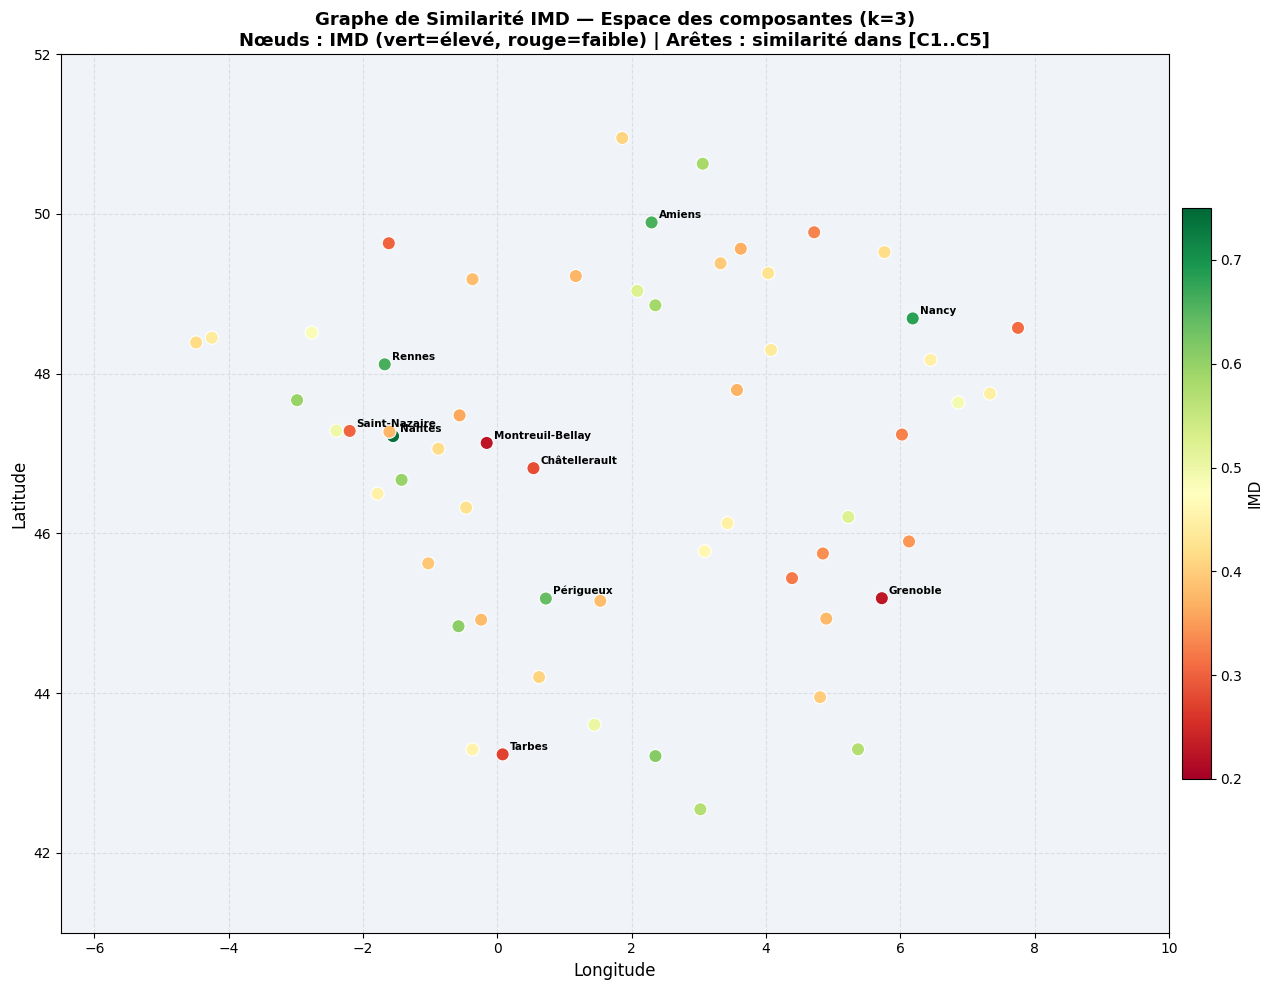

Figure C sauvegardée → ../../output/24_Graph_Spatial_IMD/figures/fig_C_similarity_graph.png


In [13]:
G = nx.Graph()
for i in range(n):
    G.add_node(i, city=cities[i], IMD=float(imd_vals[i]))
for i, j, d in sim_edges:
    w = 1.0 / (d + 1e-9)
    if G.has_edge(i, j):
        G[i][j]['weight'] = max(G[i][j]['weight'], w)
    else:
        G.add_edge(i, j, weight=w)

pos = {i: (df_metro.iloc[i]['lon'], df_metro.iloc[i]['lat']) for i in range(n)}
edge_ws = np.array([G[u][v]['weight'] for u, v in G.edges()])
ew_norm = 0.3 + 2.5 * (edge_ws - edge_ws.min()) / (edge_ws.max() - edge_ws.min() + 1e-9)

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_facecolor('#f0f4f8')

# Edges
for (u, v), lw in zip(G.edges(), ew_norm):
    ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
            color='#6baed6', lw=lw, alpha=0.55, zorder=1)

# Nodes (colored by IMD)
sc = ax.scatter(
    [pos[i][0] for i in range(n)], [pos[i][1] for i in range(n)],
    c=imd_vals, cmap='RdYlGn', s=90, vmin=0.2, vmax=0.75,
    edgecolors='white', linewidths=0.8, zorder=3)

top5 = set(df_metro.nlargest(5,'IMD')['city'])
bot5 = set(df_metro.nsmallest(5,'IMD')['city'])
for i, city in enumerate(cities):
    if city in top5 or city in bot5:
        ax.annotate(city, pos[i], textcoords='offset points', xytext=(5,3),
                    fontsize=7.5, zorder=4, fontweight='bold')

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.01)
cbar.set_label('IMD', fontsize=11)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(
    f"Graphe de Similarité IMD — Espace des composantes (k={K_SIM})\n"
    "Nœuds : IMD (vert=élevé, rouge=faible) | Arêtes : similarité dans [C1..C5]",
    fontsize=13, fontweight='bold')
ax.set_xlim(-6.5, 10); ax.set_ylim(41, 52)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_C_similarity_graph.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure C sauvegardée → {fig_path}")


In [14]:
# 1 — LISA results
df_lisa_export = df_metro[[
    'rang','city','IMD','C1_S','C2_E','C3_D','C4_P','C5_M',
    'lat','lon','Li','p_lisa','lisa_label','z_std','Wz_std'
]].copy()
df_lisa_export.to_csv(f"{TABLES_DIR}/lisa_results.csv", index=False, encoding='utf-8')

# 2 — Moran's I summary
df_moran_sum = pd.DataFrame({
    'metric': ["I observé","E[I] sous H0","Z-score","p-valeur","n","k","N permutations"],
    'value':  [round(I_obs,4), round(E_I,4), round(float(z_score),3),
               round(p_moran,4), len(df_metro), K_SPATIAL, N_PERM]
})
df_moran_sum.to_csv(f"{TABLES_DIR}/morans_I_summary.csv", index=False, encoding='utf-8')

# 3 — Peer recommendations
df_recs.to_csv(f"{TABLES_DIR}/peer_recommendations.csv", index=False, encoding='utf-8')

print("Exports sauvegardés ✓")
print()
print("=== RÉSUMÉ FINAL ===")
print(f"Moran's I   = {I_obs:.4f}")
print(f"p-valeur    = {p_moran:.4f}")
dist_lisa   = dict(df_metro['lisa_label'].value_counts())
print(f"LISA        = {dist_lisa}")
print(f"Recommandations : {len(df_recs)} villes sous la médiane IMD ({imd_median:.3f})")


Exports sauvegardés ✓

=== RÉSUMÉ FINAL ===
Moran's I   = -0.0231
p-valeur    = 0.7650
LISA        = {'NS': np.int64(56), 'HL': np.int64(1), 'LH': np.int64(1)}
Recommandations : 29 villes sous la médiane IMD (0.420)


## Conclusions

### Autocorrélation spatiale (Moran's I)
L'analyse de Moran's I révèle si l'IMD présente un regroupement géographique non aléatoire.
Un I > 0 avec p < 0.05 indique un **clustering positif** : les villes à forte mobilité douce
tendent à être entourées d'autres villes à forte mobilité douce.

### Clusters LISA
- **HH (rouge)** : villes très bien classées dans des zones géographiquement favorables
- **LL (bleu)** : déserts de mobilité douce regroupés
- **HL/LH** : outliers spatiaux — villes atypiques par rapport à leur voisinage

### Système de recommandation par pairs
Pour chaque ville sous la médiane IMD, on identifie la ville la plus « similaire »
(distance euclidienne minimale dans l'espace [C1..C5]) parmi les villes performantes.
Cette ville pair partage un profil structurel comparable (taille, densité, équité)
mais a réussi à atteindre un score IMD plus élevé — elle peut servir de modèle.

## Références
- Anselin, L. (1995). Local Indicators of Spatial Association — LISA. *Geographical Analysis*, 27(2), 93–115.
- Moran, P.A.P. (1950). Notes on continuous stochastic phenomena. *Biometrika*, 37(1), 17–23.
- Cliff, A. & Ord, J.K. (1981). *Spatial Processes: Models and Applications*. Pion.
- Newman, M.E.J. (2010). *Networks: An Introduction*. Oxford University Press.
